import libraries

In [1]:
import matplotlib. pyplot as plt
import pandas as pd
import seaborn as sns
import pickle as pkl
import numpy as np
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn. linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix


reading dataset

In [2]:
dataset = pd.read_excel(r'C:\liver_cirrhosis_project\training\HealthCareData.xlsx')

df=dataset.head()

handling missing values

In [3]:
df.shape
df.isnull().any()
df.isnull().sum()


S.NO                                                                       0
Age                                                                        0
Gender                                                                     0
Place(location where the patient lives)                                    0
Duration of alcohol consumption(years)                                     0
Quantity of alcohol consumption (quarters/day)                             0
Type of alcohol consumed                                                   0
Hepatitis B infection                                                      0
Hepatitis C infection                                                      0
Diabetes Result                                                            0
Blood pressure (mmhg)                                                      0
Obesity                                                                    0
Family history of cirrhosis/ hereditary                                    0

categorical features

In [4]:
categorical_features = df. select_dtypes(include=[object])
categorical_features.columns

Index(['Gender', 'Place(location where the patient lives)',
       'Type of alcohol consumed', 'Hepatitis B infection',
       'Hepatitis C infection', 'Diabetes Result', 'Blood pressure (mmhg)',
       'Obesity', 'Family history of cirrhosis/ hereditary', 'TG', 'LDL',
       'Total Bilirubin    (mg/dl)', 'A/G Ratio',
       'USG Abdomen (diffuse liver or  not)',
       'Predicted Value(Out Come-Patient suffering from liver  cirrosis or not)'],
      dtype='object')

Handling Outliers in Data 

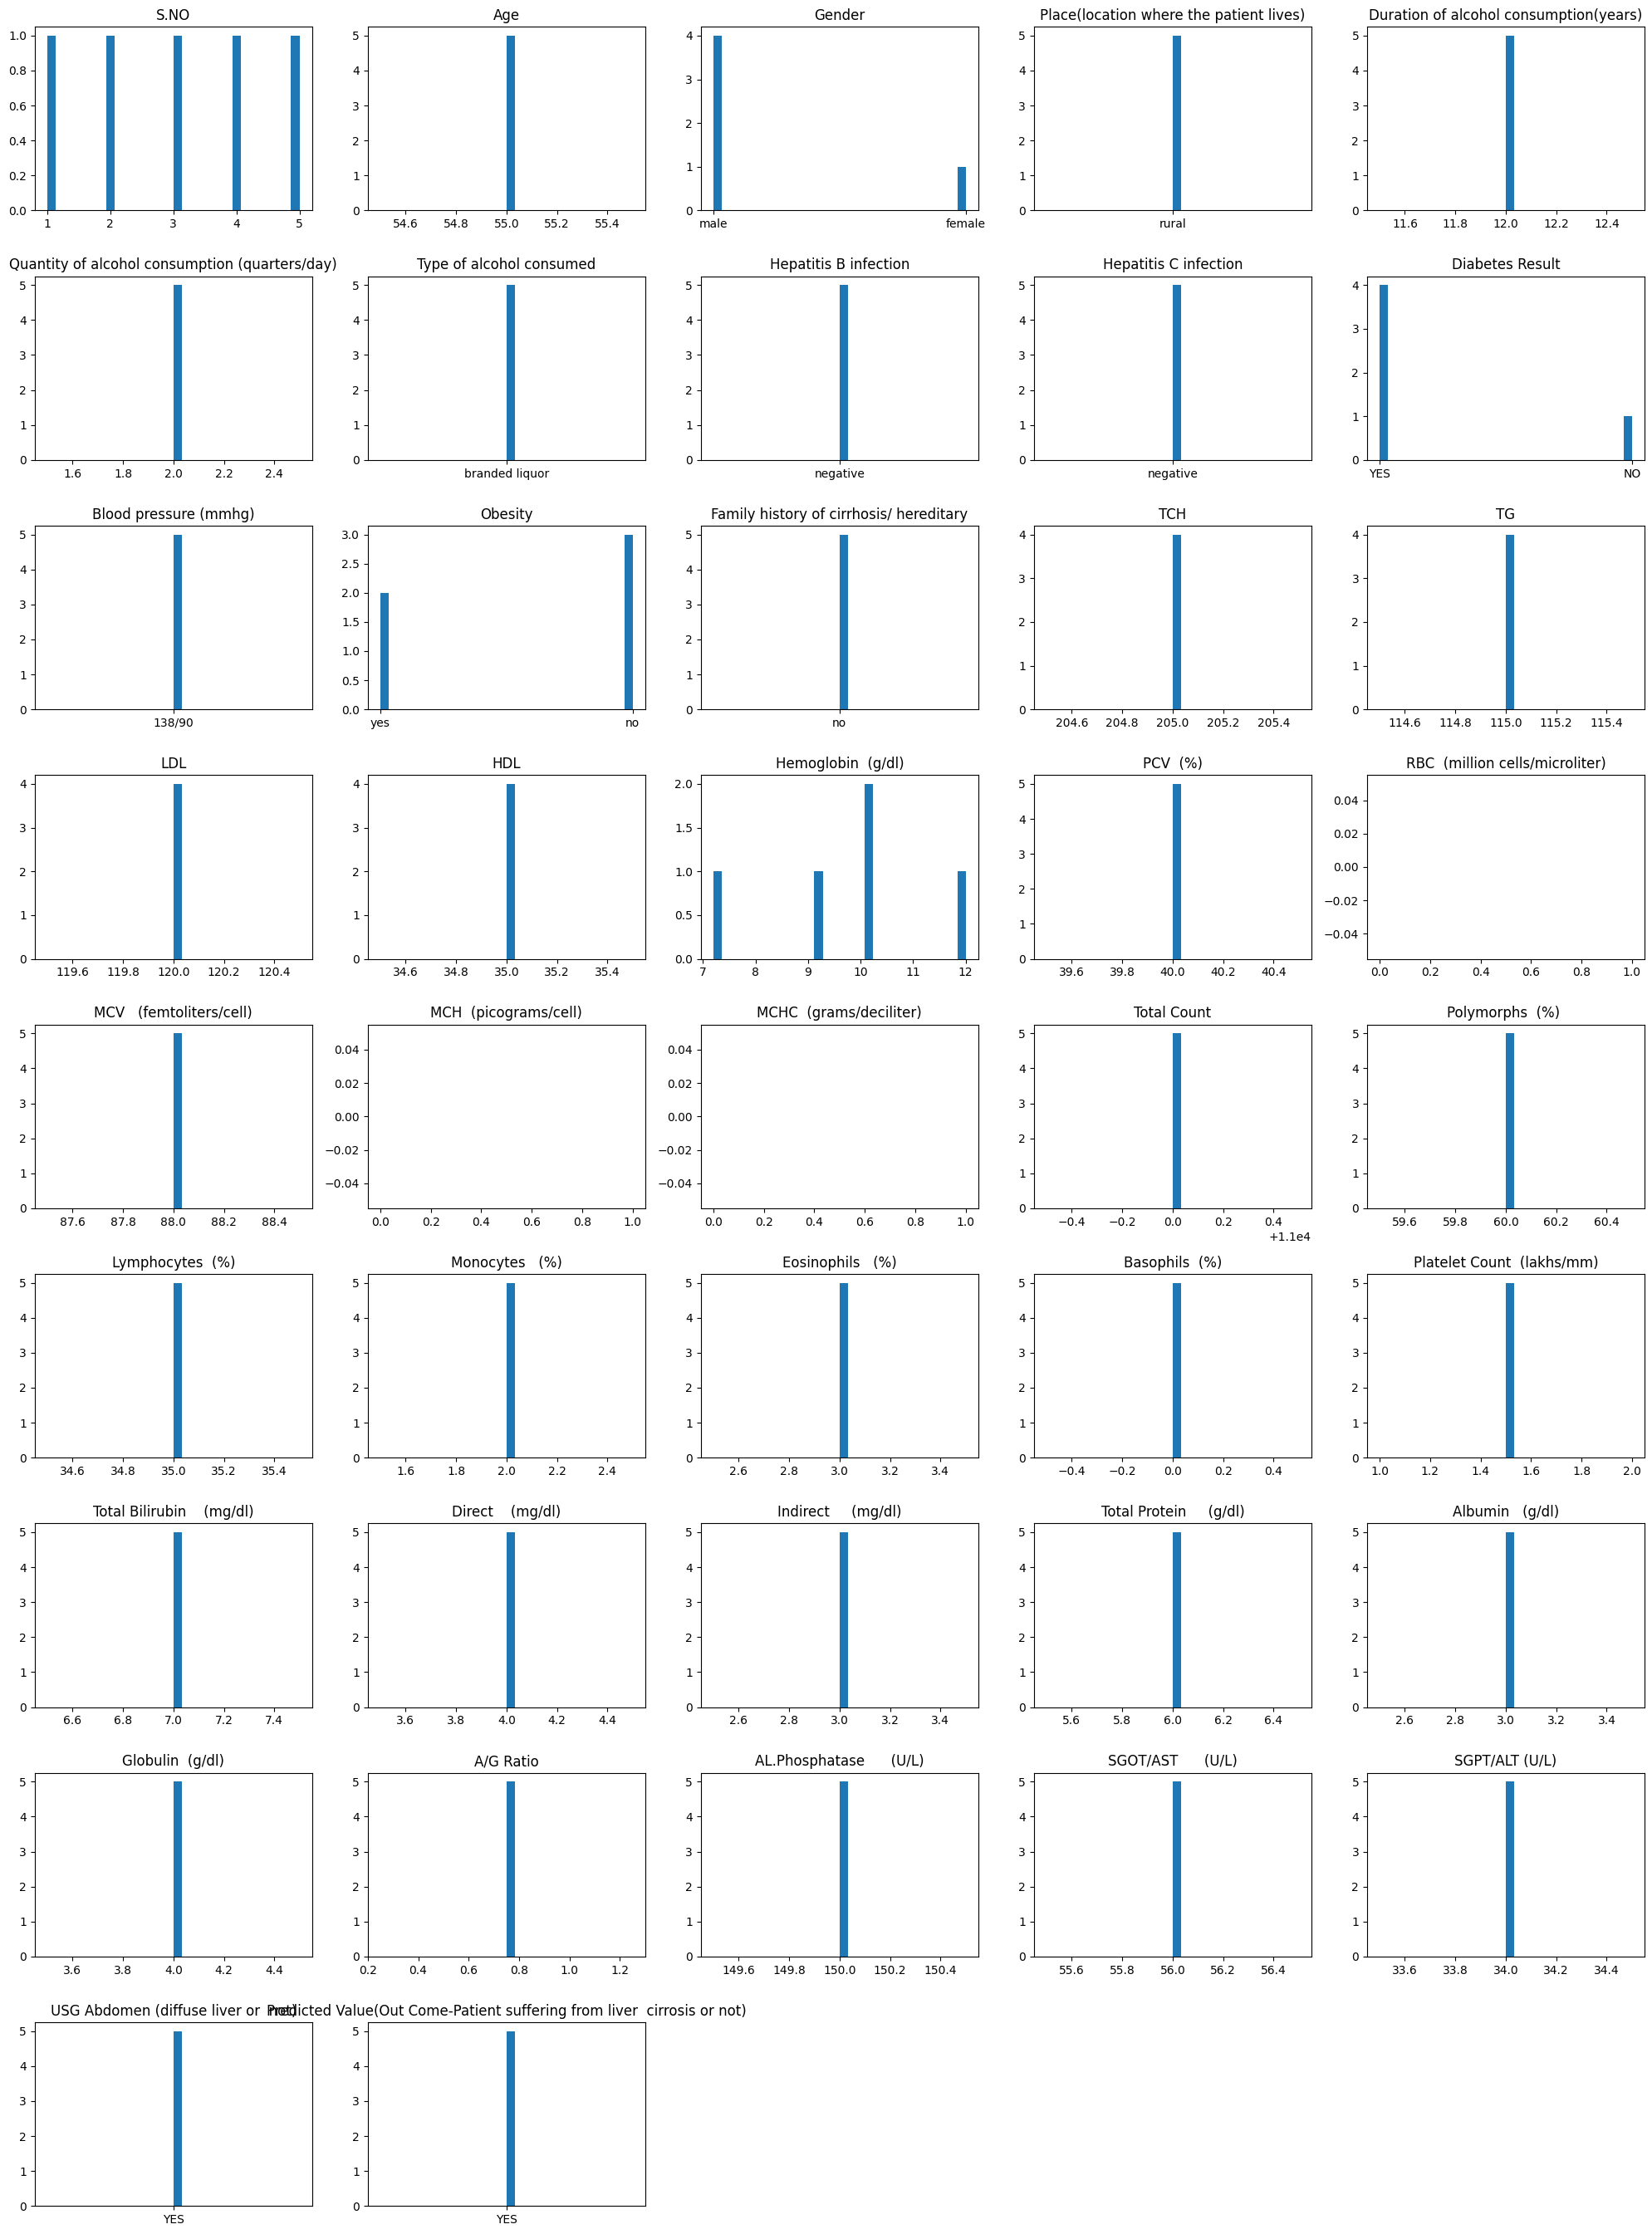

In [5]:
import math

n_cols = 5
n_plots = len(df.columns)
n_rows = math.ceil(n_plots / n_cols)

plt.figure(figsize=(20, n_rows * 3))

for c, col in enumerate(df.columns):
    plt.subplot(n_rows, n_cols, c + 1)
    plt.hist(df[col].dropna(), bins=30)
    plt.title(col)

plt.tight_layout()
plt.show()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_18872\2528614899.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where(df[col] > upper_limit, upper_limit,
C:\Users\ASUS\AppData\Local\Temp\ipykernel_18872\2528614899.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = np.where(df[col] > upper_limit, upper_limit,


<Axes: ylabel='Eosinophils (%)'>

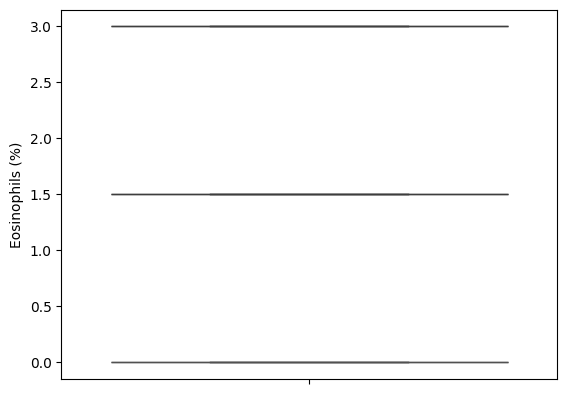

In [6]:
# Clean all column names: remove extra spaces and line breaks
df.columns = df.columns.str.strip().str.replace(r'\s+', ' ', regex=True)

# Fix outliers in Eosinophils (%) using IQR method
col = 'Eosinophils (%)'
q1 = df[col].quantile(0.25)
q3 = df[col].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df[col] = np.where(df[col] > upper_limit, upper_limit,
            np.where(df[col] < lower_limit, lower_limit, df[col]))

sns.boxplot(df[col])  # Optional: visualize after fixing

# Fix outliers in Basophils (%) using IQR method
col = 'Basophils (%)'
q1 = df[col].quantile(0.25)
q3 = df[col].quantile(0.75)
iqr = q3 - q1
lower_limit = q1 - 1.5 * iqr
upper_limit = q3 + 1.5 * iqr

df[col] = np.where(df[col] > upper_limit, upper_limit,
            np.where(df[col] < lower_limit, lower_limit, df[col]))

sns.boxplot(df[col])  # Optional: visualize after fixing

# Visualize another column
sns.boxplot(df['Platelet Count (lakhs/mm)'])


encoding

In [7]:
from sklearn.preprocessing import LabelEncoder


categorical_cols = [
    'Gender',
    'Place(location where the patient lives)',
    'Type of alcohol consumed',
    'Hepatitis B infection',
    'Hepatitis C infection',
    'Diabetes Result',
    'Blood pressure (mmhg)',
    'Obesity',
    'Family history of cirrhosis/ hereditary',
    'USG Abdomen (diffuse liver or not)'
]

# Make a copy of your original DataFrame
df_encoded = df.copy()

# Apply label encoding
le = LabelEncoder()
for col in categorical_cols:
    df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

selected features

In [8]:
# Define selected features and target column
selected_features = [
    'Age',
    'Gender',
    'Duration of alcohol consumption(years)',
    'Quantity of alcohol consumption (quarters/day)',
    'Hepatitis B infection',
    'Hepatitis C infection',
    'Diabetes Result',
    'Total Bilirubin (mg/dl)',
    'Albumin (g/dl)',
    'SGOT/AST (U/L)'
]

target_col = 'Predicted Value(Out Come-Patient suffering from liver cirrosis or not)'

data split and train

In [9]:
df.columns = df.columns.str.strip().str.replace(r'\s+', ' ', regex=True)
X = df_encoded[selected_features]
y = df_encoded[target_col]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


normalization

In [10]:
from sklearn.impute import SimpleImputer

# Create imputer (using mean strategy for numerical features)
imputer = SimpleImputer(strategy='mean')

# Fit on training data and transform both train and test
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)
# Normalize the imputed data
normalizer = Normalizer(norm='l1')
X_train_normalized = normalizer.fit_transform(X_train_imputed)
X_test_normalized = normalizer.transform(X_test_imputed)


In [11]:
print("Shape of X_train_norm:", X_train_normalized.shape)


Shape of X_train_norm: (4, 10)


train model

In [12]:
# Step 1: Define the model
rf_modal = RandomForestClassifier(random_state=42)

# Step 2: Fit the model to training data
rf_modal.fit(X_train_normalized, y_train)


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


making predictions

In [13]:
y_pred =rf_modal.predict(X_test)


C:\Users\ASUS\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\validation.py:2742: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


evaluation

In [14]:
print(accuracy_score(y_test, y_pred))


1.0


saving models

In [15]:
import joblib
joblib.dump(rf_modal, 'rf_acc_68.pkl')
joblib.dump(normalizer, 'normalizer.pkl')
print("✅ New model saved with 10 features")

✅ New model saved with 10 features


In [16]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train_normalized, y_train)

print("Model trained on:", rf_model.n_features_in_, "features")


Model trained on: 10 features
